In [1]:
import pandas as pd

jobs = pd.read_csv("filtered_jobs.csv")
jobs.sample(2)

,id,job_id,company_display_name,location,title,latitude,longitude,redirect_url,description,category_tag,contract_time,created,company_name_clean
479,832,5533891218,médiane benelux,"alken, tongeren",test rig software and integration engineer,50.89829,5.30732,https://www.adzuna.be/details/5533891218?utm_m...,we are looking for an r&d test software engine...,it-jobs,NaN,2025-12-08t20:16:28z,médiane_benelux
188,202,5491603166,telus digital,belgië,virtual work: online data analyst - dutch in b...,NaN,NaN,https://www.adzuna.be/details/5491603166?utm_m...,are you a detail-oriented individual with a pa...,unknown,NaN,2025-11-12t08:39:16z,telus_digital


In [17]:
pd.set_option("display.max_colwidth", 500)
jobs.iloc[100]

id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      105
job_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [ ]:
# # count number of tokens in description - TEST
# test_string = jobs.iloc[1]["description"]

# import tiktoken 

# encode_tokens = tiktoken.encoding_for_model("gpt-4o-mini")
# tokenized = len(encode_tokens.encode(test_string))
# tokenized

95

In [2]:
from utils import count_tokens_per_row

jobs["token_count_description"] = count_tokens_per_row("gpt-4o-mini", jobs, "description")

In [4]:
import plotly.express as px

fig = px.histogram(
    data_frame=jobs, x="token_count_description",
    nbins=40,
    histnorm="probability density")

fig.show()

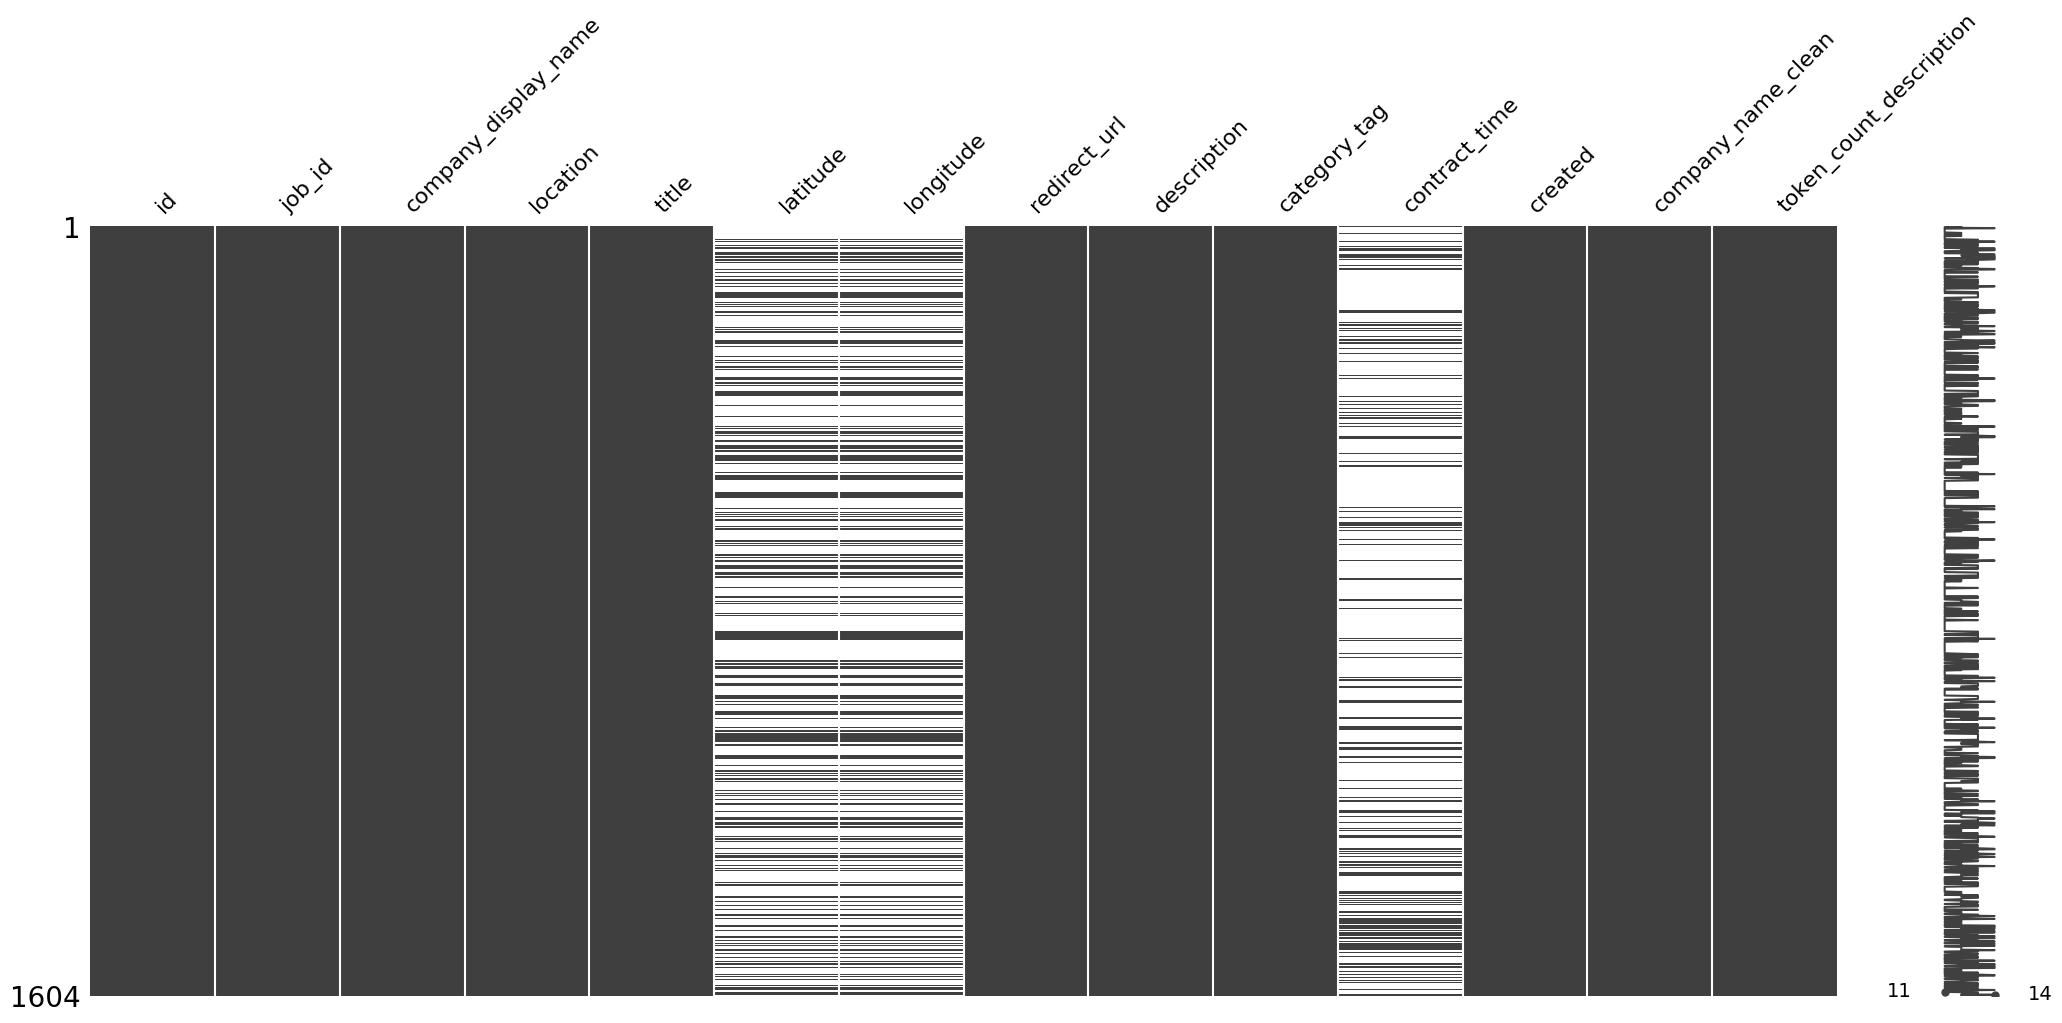

In [5]:
import missingno as msno
import matplotlib.pyplot as plt

msno.matrix(jobs)
plt.show()

In [6]:
from ydata_profiling import ProfileReport

profile = ProfileReport(jobs, title="Descriptive Stats of Tech/Data Jobs (2025)")
profile.to_file("jobs_report_2025.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 225.99it/s]


In [2]:
jobs_dict = jobs[["job_id","company_display_name", "title", "description"]].to_dict(orient="records")
test = jobs_dict[:3]
test

[{'job_id': 5532749858,
  'company_display_name': 'johnson & johnson',
  'title': 'sr director, head of data science & digital health – therapeutics development & supply (tds)',
  'description': 'at johnson & johnson, we believe health is everything. our strength in healthcare innovation empowers us to build a world where complex diseases are prevented, treated, and cured, where treatments are smarter and less invasive, and solutions are personal. through our expertise in innovative medicine and medtech, we are uniquely positioned to innovate across the full spectrum of healthcare solutions today to deliver the breakthroughs of tomorrow, and profoundly impact health for humanity. learn …'},
 {'job_id': 5532749786,
  'company_display_name': 'bjak',
  'title': 'founding ai engineer',
  'description': 'transform language models into real-world, high-impact product experiences. a1 is a self-funded ai group, operating in full stealth. we’re building a new global consumer ai application focu

In [12]:
print(test[0]["description"])

at johnson & johnson, we believe health is everything. our strength in healthcare innovation empowers us to build a world where complex diseases are prevented, treated, and cured, where treatments are smarter and less invasive, and solutions are personal. through our expertise in innovative medicine and medtech, we are uniquely positioned to innovate across the full spectrum of healthcare solutions today to deliver the breakthroughs of tomorrow, and profoundly impact health for humanity. learn …


In [3]:
from openai import OpenAI
from utils import llm_instructions, map_progress, user_prompt, build_user_prompt, JobPostingExtraction
from concurrent.futures import ThreadPoolExecutor

client = OpenAI()
def llm_structured(llm_instructions:str, user_prompt:str, output_format=JobPostingExtraction, model="gpt-4o-mini"):


    messages = [
        {"role": "system", "content": llm_instructions},
        {"role": "user", "content": user_prompt}
    ]

    response = client.responses.parse(
        model=model,
        input=messages,
        text_format=output_format
    )
    return (response.output_parsed, response.usage)

def run_llm(row):
    user_prompt = build_user_prompt(
        company_display_name=row["company_display_name"], 
        job_title=row["title"], 
        job_description=row["description"])

    output = llm_structured(
        llm_instructions=llm_instructions, 
        user_prompt=user_prompt
        )
    return row, output

with ThreadPoolExecutor(max_workers=6) as pool:
    results = map_progress(pool, test, run_llm)


   

100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


In [4]:
all_extracted_response = []
for original_row, result in results:
    extraction, usage = result

    temp = {
        **extraction.model_dump(),
        "job_title": extraction.job_title.value,
        "seniority": extraction.seniority.value,
        "input_tokens": usage.input_tokens,
        "output_tokens": usage.output_tokens,
        "total_tokens": usage.total_tokens,
    }

    all_extracted_response.append(temp)
all_extracted_response

[{'job_title': 'data scientist',
  'seniority': 'director',
  'clean_title': 'Senior Director, Head of Data Science & Digital Health',
  'skills': [],
  'job_description_summary': 'The Senior Director will lead data science and digital health initiatives within therapeutics development and supply.',
  'company_description': 'Johnson & Johnson is a leader in healthcare innovation focused on preventing, treating, and curing complex diseases. With expertise in innovative medicine and medtech, the company aims to deliver significant breakthroughs in healthcare solutions that profoundly impact health for humanity.',
  'company_description_confidence_score': 0.9,
  'input_tokens': 878,
  'output_tokens': 111,
  'total_tokens': 989},
 {'job_title': 'machine learning engineer',
  'seniority': 'lead',
  'clean_title': 'Founding AI Engineer',
  'skills': [],
  'job_description_summary': 'The role involves transforming language models into impactful product experiences, shaping the core technical

In [18]:
import pandas as pd
pd.DataFrame(all_extracted_response)

,job_title,seniority,clean_title,skills,job_description_summary,company_description,company_description_confidence_score,input_tokens,output_tokens,total_tokens
0,data scientist,director,"Senior Director, Head of Data Science & Digital Health",[],The Senior Director will lead data science and digital health initiatives within therapeutics development and supply.,"Johnson & Johnson is a leader in healthcare innovation focused on preventing, treating, and curing complex diseases. With expertise in innovative medicine and medtech, the company aims to deliver significant breakthroughs in healthcare solutions that profoundly impact health for humanity.",0.9,878,111,989
1,machine learning engineer,lead,Founding AI Engineer,[],"The role involves transforming language models into impactful product experiences, shaping the core technical direction of a self-funded AI group focused on a global consumer AI application.","bjak is an innovative AI group operating in stealth mode, dedicated to creating a new consumer-focused AI application that addresses an important yet underexplored use case. The team is involved in defining model stacks, data strategy, and product capabilities.",0.9,867,120,987
2,data engineer,mid,Data & AI Engineer,[],"The Data & AI team supports the House of HR portfolio by building, deploying, and operationalizing AI products. They collaborate with AI champions and field staff to understand needs and architect end-to-end AI systems.",House of HR is a company that specializes in providing human resources solutions and services. Their focus includes the development and deployment of AI products to enhance operational efficiency across their portfolio.,0.9,871,116,987
